In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import itertools
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load and Preprocess the Dataset

In [2]:
# Load the dataset
data = pd.read_csv("Dataset/diabetes.csv")
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values * 2 - 1  # converting 0 to -1 and 1 to +1

# Scale the features between 0 and 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


# Model Implementation

## Single-Layer Perceptron (SLP) Model

In [8]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.fc(x))


## Multi-Layer Perceptron (MLP) Model

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(MLP, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims + [1]
        
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims) - 2:  # Exclude the last layer
                layers.append(nn.ReLU())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return torch.sigmoid(self.network(x))
    

# Model Training and Evaluation

In [4]:
# Combine train and validation sets
X_combined = torch.cat((X_train, X_val), 0)
y_combined = torch.cat((y_train, y_val), 0)

## Single-Layer Perceptron (SLP) Model

### Base Single-Layer Perceptron

In [9]:
Base_SLP_model = Perceptron(input_dim=8)
criterion = nn.BCELoss()
optimizer = optim.SGD(Base_SLP_model.parameters(), lr=0.01)
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(100):
    optimizer.zero_grad()
    output = Base_SLP_model(X_train).squeeze()
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    with torch.no_grad():
        val_output = Base_SLP_model(X_val).squeeze()
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss.item())
        train_acc = accuracy_score(y_train.numpy(), [1 if o > 0.5 else -1 for o in output.detach().numpy()])
        val_acc = accuracy_score(y_val.numpy(), [1 if o > 0.5 else -1 for o in val_output.detach().numpy()])
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

print(f"Base SLP Model Training Accuracy after 100 epochs: {train_accuracies[-1]}")
print(f"Base SLP Model Validation Accuracy after 100 epochs: {val_accuracies[-1]}")


Base SLP Model Training Accuracy after 100 epochs: 0.7217391304347827
Base SLP Model Validation Accuracy after 100 epochs: 0.7792207792207793


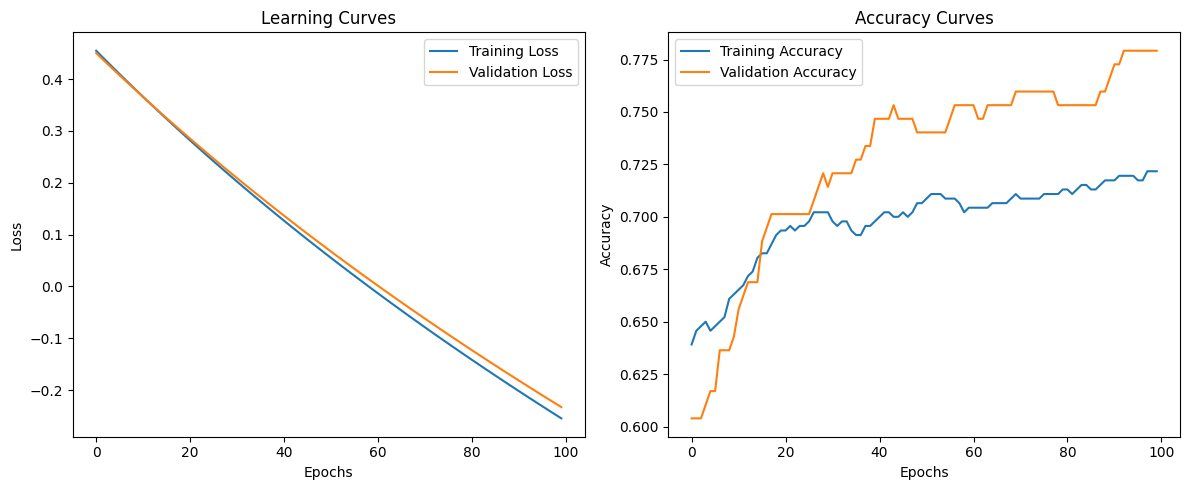

In [10]:
# Learning Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()

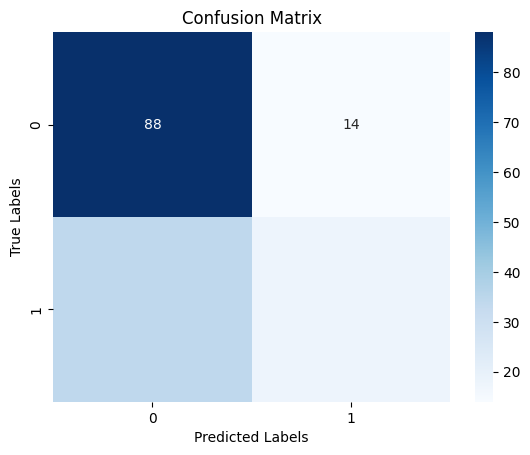

In [11]:
# Confusion Matrix
test_predictions = [1 if o > 0.5 else -1 for o in Base_SLP_model(X_test).squeeze().detach().numpy()]
confusion = confusion_matrix(y_test, test_predictions)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
test_output = Base_SLP_model(X_test).squeeze()
test_predictions = [1 if o > 0.5 else -1 for o in test_output.detach().numpy()]
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

        -1.0       0.72      0.86      0.79       102
         1.0       0.56      0.35      0.43        52

    accuracy                           0.69       154
   macro avg       0.64      0.60      0.61       154
weighted avg       0.67      0.69      0.67       154



### Optimized Single-Layer Perceptron

In [25]:
# Grid for hyperparameter tuning
param_grid = {
    'lr': [0.0001, 0.001, 0.01, 0.1],
    'num_epochs': [10, 50, 100, 1000],
    'weight_decay': [0.00001, 0.001, 0.01, 0.1, 0.2, 1] # Regularization strengths
}

best_val_accuracy = 0
best_params = {}
patience = 5  # for early stopping
early_stopping_counter = 0

for lr in param_grid['lr']:
    for epoch in param_grid['num_epochs']:
        for decay in param_grid['weight_decay']:
            early_stopping_counter = 0  # Reset for each combination of hyperparameters
            SLP_model = Perceptron(input_dim=8)
            criterion = nn.BCELoss()
            optimizer = optim.SGD(SLP_model.parameters(), lr=lr, weight_decay=decay)

            prev_val_loss = float('inf')
            
            for e in range(epoch):
                optimizer.zero_grad()
                output = SLP_model(X_train).squeeze()
                loss = criterion(output, y_train)
                loss.backward()
                optimizer.step()

                # Validation for early stopping
                with torch.no_grad():
                    val_output = SLP_model(X_val).squeeze()
                    val_loss = criterion(val_output, y_val)
                
                if val_loss >= prev_val_loss:
                    early_stopping_counter += 1
                else:
                    early_stopping_counter = 0

                if early_stopping_counter >= patience:
                    break

                prev_val_loss = val_loss
            
            val_predictions = [1 if o > 0.5 else -1 for o in val_output.detach().numpy()]
            accuracy = accuracy_score(y_val, val_predictions)
            
            if accuracy > best_val_accuracy:
                best_val_accuracy = accuracy
                best_params = {'lr': lr, 'epoch': epoch, 'decay': decay}
                best_model_state = SLP_model.state_dict()  # Save the best model state

print("Best validation accuracy :", best_val_accuracy)
print("Best Hyperparameters :", best_params)

Best validation accuracy : 0.7922077922077922
Best Hyperparameters : {'lr': 0.01, 'epoch': 100, 'decay': 1e-05}


In [26]:
# Retraining with the best hyperparameters
SLP_model = Perceptron(input_dim=8)
criterion = nn.BCELoss()
optimizer = optim.SGD(SLP_model.parameters(), lr=best_params['lr'], weight_decay=best_params['decay'])
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(best_params['epoch']):
    optimizer.zero_grad()
    output = SLP_model(X_train).squeeze()
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    with torch.no_grad():
        val_output = SLP_model(X_val).squeeze()
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss.item())
        train_acc = accuracy_score(y_train.numpy(), [1 if o > 0.5 else -1 for o in output.detach().numpy()])
        val_acc = accuracy_score(y_val.numpy(), [1 if o > 0.5 else -1 for o in val_output.detach().numpy()])
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

print(f"Optimized SLP Model Training Accuracy after {best_params['epoch']} epochs: {train_accuracies[-1]}")
print(f"Optimized SLP Model Validation Accuracy after {best_params['epoch']} epochs: {val_accuracies[-1]}")

Optimized SLP Model Training Accuracy after 100 epochs: 0.6847826086956522
Optimized SLP Model Validation Accuracy after 100 epochs: 0.7142857142857143


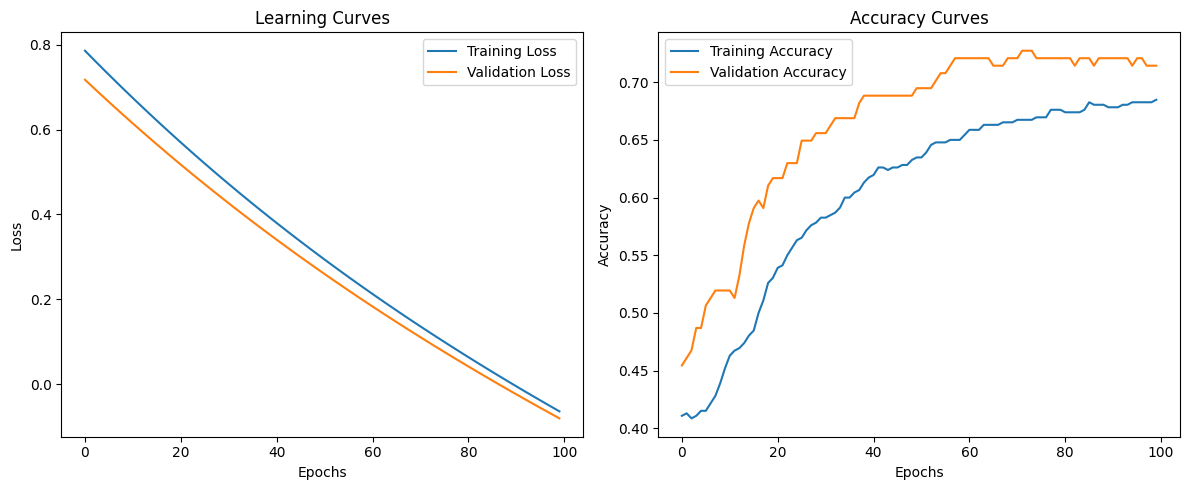

In [27]:
# Learning Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
best_model = Perceptron(input_dim=8)
best_model.load_state_dict(best_model_state)
test_output = best_model(X_test).squeeze()
test_predictions = [1 if o > 0.5 else -1 for o in test_output.detach().numpy()]
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

        -1.0       0.77      0.86      0.81       102
         1.0       0.64      0.48      0.55        52

    accuracy                           0.73       154
   macro avg       0.70      0.67      0.68       154
weighted avg       0.72      0.73      0.72       154



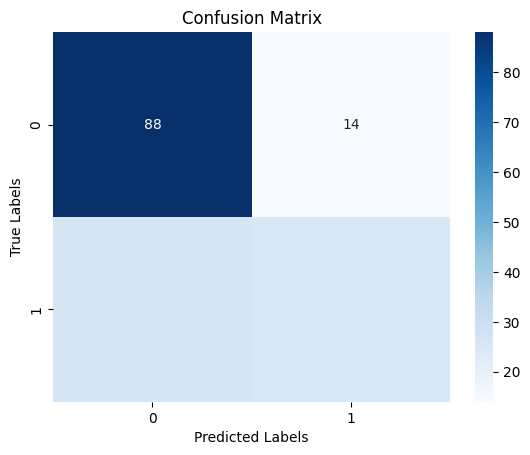

In [29]:
# Confusion Matrix
test_predictions = [1 if o > 0.5 else -1 for o in best_model(X_test).squeeze().detach().numpy()]
confusion = confusion_matrix(y_test, test_predictions)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Multi-Layer Perceptron (MLP) Model

In [5]:
param_grid = {
    'lr': [0.0001, 0.001, 0.01, 0.1],
    'num_epochs': [10, 50, 100, 1000],
    'weight_decay': [0.00001, 0.001, 0.01, 0.1, 0.2, 1], # Regularization strengths
    'hidden_dims': [[8], [16], [8, 8], [16, 8], [8, 16, 8]]  # Different layer combinations
}

best_val_accuracy = 0
best_params = {}
patience = 5  # for early stopping
early_stopping_counter = 0

for lr in param_grid['lr']:
    for epoch in param_grid['num_epochs']:
        for decay in param_grid['weight_decay']:
            for hidden_dims in param_grid['hidden_dims']:
                
                model = MLP(input_dim=8, hidden_dims=hidden_dims)
                criterion = nn.BCELoss()
                optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=decay)

                prev_val_loss = float('inf')
                
                for e in range(epoch):
                    optimizer.zero_grad()
                    output = model(X_train).squeeze()
                    loss = criterion(output, y_train)
                    loss.backward()
                    optimizer.step()

                    # Validation for early stopping
                    with torch.no_grad():
                        val_output = model(X_val).squeeze()
                        val_loss = criterion(val_output, y_val)
                    
                    if val_loss >= prev_val_loss:
                        early_stopping_counter += 1
                    else:
                        early_stopping_counter = 0

                    if early_stopping_counter >= patience:
                        break

                    prev_val_loss = val_loss
                
                val_predictions = [1 if o > 0.5 else -1 for o in val_output.detach().numpy()]
                accuracy = accuracy_score(y_val, val_predictions)
                
                if accuracy > best_val_accuracy:
                    best_val_accuracy = accuracy
                    best_params = {'lr': lr, 'epoch': epoch, 'decay': decay, 'hidden_dims': hidden_dims}
                    
                    
print("Best validation accuracy :", best_val_accuracy)
print("Best Hyperparameters :", best_params)

Best validation accuracy : 0.7857142857142857
Best Hyperparameters : {'lr': 0.1, 'epoch': 1000, 'decay': 0.1, 'hidden_dims': [8, 16, 8]}


In [6]:
model = MLP(input_dim=8, hidden_dims=best_params['hidden_dims'])
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=best_params['lr'], weight_decay=best_params['decay'])

for epoch in range(best_params['epoch']):
    optimizer.zero_grad()
    output = model(X_combined).squeeze()
    loss = criterion(output, y_combined)
    loss.backward()
    optimizer.step()

# Evaluation on Test Data
with torch.no_grad():
    test_output = model(X_test).squeeze()
    test_predictions = [1 if o > 0.5 else -1 for o in test_output.detach().numpy()]

print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

        -1.0       0.74      0.96      0.84       102
         1.0       0.82      0.35      0.49        52

    accuracy                           0.75       154
   macro avg       0.78      0.65      0.66       154
weighted avg       0.77      0.75      0.72       154

